In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # 정규식 사용을 위한 모듈
# from scipy.stats import gaussian_kde

import pyarrow.parquet as pq

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window
from pyspark.sql.functions import broadcast, element_at, regexp_extract, udf, col, isnull, count, when, substring, coalesce, from_json, size, avg, expr, concat_ws
from pyspark.sql.types import ArrayType, StringType, StructType, StructField, DoubleType, IntegerType, FloatType

from functools import reduce
from matplotlib.ticker import FuncFormatter
from collections import Counter
from datetime import datetime

In [2]:
# 가상 환경의 Python 경로를 지정
python_path = "C:/Users/admin/anaconda3/envs/my_conda_01/python.exe"

# Spark 세션 생성
spark = SparkSession.builder \
    .appName("voice_metadata integrating operation") \
    .config("spark.driver.memory", "9g") \
    .config("spark.executor.memory", "9g") \
    .config("spark.driver.maxResultSize", "5g") \
    .config("spark.pyspark.python", python_path) \
    .config("spark.local.dir", "D:/spark_tmp") \
    .getOrCreate()

# SparkContext 가져오기
sc = spark.sparkContext

# Spark 중간 파일이 저장되는 경로 확인
current_spark_local_dir = spark.conf.get("spark.local.dir", "Not Set")
print("Spark local directory:", current_spark_local_dir)

Spark local directory: D:/spark_tmp


In [3]:
# Parquet 파일의 경로
file_path = 'D:\\DATA_PREPROCESS\\FIRESTORE_DATAS\\voice_metadata_parquet_231030_특성엔지니어링_수정후\\*.parquet'

# Parquet 파일을 읽어서 DataFrame에 저장
spark_df = spark.read.parquet(file_path)
# df = pd.read_parquet(file_path, engine='pyarrow')

In [4]:
spark_df.printSchema()

root
 |-- ad_name: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- stt_text_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- attend: double (nullable = true)
 |-- is_passed: string (nullable = true)
 |-- imageUrl: string (nullable = true)
 |-- ad_script: string (nullable = true)
 |-- accuracy_array: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- created_timestamp_array: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ad_title: string (nullable = true)
 |-- birth_year: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- is_test: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- job: string (nullable = true)
 |-- language: string (nullable = true)
 |-- perfect: double (nullable = true)
 |-- excepted_age_array: string (nullable = true)
 |-- collection: string (nullable = true)
 |-- ad_duration: string (nullable = true)
 |-- ad_duration_

In [5]:
spark_df.count()

14045909

# birth_year 컬럼 체크

In [14]:
# 'birth_year' 컬럼의 고유한 값과 그 빈도수를 계산
birth_year_counts = spark_df.groupBy("birth_year").count()

# 결과를 'count' 컬럼에 따라 내림차순으로 정렬
birth_year_counts_ordered = birth_year_counts.orderBy(F.desc("count"))

# DataFrame의 전체 행 수를 얻습니다.
total_rows = birth_year_counts_ordered.count()

# 결과를 출력
birth_year_counts_ordered.show(total_rows, truncate=False)

+----------+------+
|birth_year|count |
+----------+------+
|68        |129675|
|null      |126714|
|65        |117439|
|69        |116363|
|80        |115733|
|70        |108976|
|82        |106277|
|79        |101115|
|74        |98599 |
|72        |98471 |
|73        |95409 |
|67        |93700 |
|78        |80460 |
|71        |79592 |
|76        |79250 |
|85        |78992 |
|66        |76698 |
|60        |75593 |
|83        |73821 |
|62        |66955 |
+----------+------+
only showing top 20 rows



# text_length 컬럼 체크
## text_length 확인

In [7]:
# text_length가 0인 row를 필터링
filtered_df = spark_df.filter(F.col('text_length') == 0)

# text_length가 0인 row를 필터링하고, 10개의 row만 수집
filtered_df_10 = filtered_df.limit(10).collect()

# 수집된 모든 컬럼값을 출력
for i, row in enumerate(filtered_df_10):
    print(f"{i+1}. {row}")

In [6]:
# # 테스트 데이터 생성
# text_data = [("대용량액상 ",), ("티맵, .",), ("탄탄한a",), ("abcd ",), ("HSAET DQ",), ("4947",)]
# ad_script_column = ["ad_script"]

# # 데이터프레임 생성
# test_df = spark.createDataFrame(text_data, ad_script_column)

# # 특수문자 제거 및 길이 계산
# test_df = test_df.withColumn("cleaned_script", F.regexp_replace(F.col("ad_script"), "[^\\s\\n.,\uAC00-\uD7A3a-zA-Z0-9]", ""))
# test_df = test_df.withColumn("text_length", F.length(F.col("cleaned_script")))

# # 결과 출력
# test_df.show()

+-----------+--------------+-----------+
|  ad_script|cleaned_script|text_length|
+-----------+--------------+-----------+
|대용량액상 |   대용량액상 |          6|
|    티맵, .|       티맵, .|          5|
|    탄탄한a|       탄탄한a|          4|
|      abcd |         abcd |          5|
|   HSAET DQ|      HSAET DQ|          8|
|       4947|          4947|          4|
+-----------+--------------+-----------+



## text_length 교정

In [5]:
spark_df = spark_df.drop('text_length')

# 'ad_name'과 'ad_script'를 그룹화하고, 각 그룹의 개수를 카운트
grouped_ad_texts = spark_df.groupBy('ad_name', 'ad_script').count()

# 'ad_name' 별로 가장 빈번한 'ad_script'를 선택
windowSpec = Window.partitionBy('ad_name').orderBy(F.desc('count'))
most_frequent_ad_texts = grouped_ad_texts.withColumn("rank", F.rank().over(windowSpec)).filter("rank = 1").drop('count', 'rank')

# 특수문자 제거 및 길이 계산
most_frequent_ad_texts = most_frequent_ad_texts.withColumn("cleaned_script", F.regexp_replace(F.col("ad_script"), "[^\\s\\n.,\uAC00-\uD7A3a-zA-Z0-9]", ""))
most_frequent_ad_texts = most_frequent_ad_texts.withColumn("text_length", F.length(F.col("cleaned_script")))

# 원래 데이터프레임에 조인
# most_frequent_ad_texts가 상대적으로 작다고 했으므로 브로드캐스팅을 사용
spark_df = spark_df.join(broadcast(most_frequent_ad_texts.select('ad_name', 'text_length')), ['ad_name'], 'left')

# accuracy 관련 컬럼 체크  
## average_accuracy_by_user 컬럼 체크

In [8]:
# user_id가 'Z77mAlLcRRbxQcW82ldEnAlOVUE2'인 행만 필터링
filtered_df = spark_df.filter(F.col("user_id") == 'Z77mAlLcRRbxQcW82ldEnAlOVUE2')

# accuracy_array 컬럼만 선택하고 수집
accuracy_array_values = filtered_df.select("accuracy_array").collect()

# 첫 번째 값들을 담을 리스트 초기화
first_values = []

# 수집된 값을 순회하면서 첫 번째 값들을 리스트에 추가
for row in accuracy_array_values:
    array_value = row["accuracy_array"]
    if array_value:
        first_values.append(array_value[0])

# 평균을 계산
if first_values:
    average_value = reduce(lambda x, y: x + y, first_values) / len(first_values)
    print(f"The average of the first values in accuracy_array is {average_value}")
else:
    print("No data available for the calculation.")

The average of the first values in accuracy_array is 83.3108759553204


# 수집된 음성데이터들의 광고 종료일의 처음과 끝

1단계: created_timestamp_array에서 첫 번째 날짜 정보를 정규 표현식으로 추출  
    (예: "['23.06.06 오후 07시...]" -> "23.06.06")    
2단계: 날짜 형식으로 변환 (예: '23.06.06' -> '2023-06-06')  
3단계: 날짜를 기준으로 DataFrame 정렬  
4단계: 첫 번째와 마지막 행의 날짜 출력    

In [ ]:
# 'created_timestamp_array'에서 첫 번째 요소를 가져옵니다.
spark_df = spark_df.withColumn('first_timestamp', element_at(spark_df['created_timestamp_array'], 1))

# 첫 번째 요소에서 날짜를 추출합니다.
spark_df = spark_df.withColumn(
    'first_created_date', 
    regexp_extract(col('first_timestamp'), r"(\d{2}\.\d{2}\.\d{2})", 1)
)

# 날짜 형식으로 변환합니다 (예: '23.06.06' -> '2023-06-06').
spark_df = spark_df.withColumn(
    'first_created_date', 
    F.expr("concat('20', substring(first_created_date, 1, 2), '-', substring(first_created_date, 4, 2), '-', substring(first_created_date, 7, 2))")
)

# 날짜를 기준으로 DataFrame 정렬합니다.
spark_df = spark_df.sort('first_created_date')

# 첫 번째와 마지막 행의 날짜를 출력합니다.
earliest_date = spark_df.select('first_created_date').limit(1).collect()[0][0]
latest_date = spark_df.select('first_created_date').orderBy(F.desc('first_created_date')).limit(1).collect()[0][0]

print(f"가장 먼저 생성된 음성파일의 날짜: {earliest_date}")
print(f"가장 나중에 생성된 음성파일의 날짜: {latest_date}")

# 월별로 Point와 Memorization의 평균을 계산 -> 막대 그래프 

In [ ]:
# plt.rc('font', family='NanumBarunGothic')  # 한글 폰트 설정, 예: 'NanumBarunGothic', 'Malgun Gothic' 등

In [ ]:
# 월 정보를 추출
spark_df = spark_df.withColumn("month", F.date_format("first_created_date", "yyyy-MM"))

# 월별로 Point와 Memorization의 카운트 계산
grouped_data = spark_df.filter(F.col("collection").isin(["Point", "Memorization"])).groupBy("month", "collection").count().sort("month", "collection")

# Spark DataFrame을 Pandas DataFrame으로 변환
pdf = grouped_data.toPandas()

# 월 정보에서 연도 부분을 축소 (예: '2023-04' -> '23-04')
pdf['short_month'] = pdf['month'].str[2:]

# Point와 Memorization에 대한 별도의 데이터 프레임 추출
point_df = pdf[pdf['collection'] == 'Point'].sort_values(by='month')
memorization_df = pdf[pdf['collection'] == 'Memorization'].sort_values(by='month')

# 막대 그래프 그리기
plt.figure(figsize=(12, 6))

# y축 레이블을 정수로 표시하고 세 자리마다 쉼표 추가
formatter = FuncFormatter(lambda x, _: '{:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

# x축 라벨을 명시적으로 지정
xticks = sorted(set(point_df['short_month'].tolist() + memorization_df['short_month'].tolist()))
x = np.arange(len(xticks))

# 막대 너비 지정
width = 0.4

# 각 데이터 프레임에 대해 막대 그래프 그리기
plt.bar(x - width/2, point_df.set_index('short_month').reindex(xticks)['count'].fillna(0), width, label='Point')
plt.bar(x + width/2, memorization_df.set_index('short_month').reindex(xticks)['count'].fillna(0), width, label='Memorization')

plt.xticks(ticks=x, labels=xticks, rotation=45)

plt.xlabel('Month')
plt.ylabel('count')
plt.title('Monthly Count of Point and Memorization')
plt.legend()
plt.show()

# # 'dummy' 값들을 제외하고 카운트
# dummy_count = spark_df.filter(~F.col("collection").isin(["Point", "Memorization"])).count()
# print(f"Number of 'dummy' values in 'collection': {dummy_count}")

## 8월 일별 데이터 추가량 출력

In [ ]:
# 8월 데이터만 필터링
aug_data = spark_df.filter((F.col("month") == "2023-08") & (F.col("collection").isin(["Point", "Memorization"])))

# 8월에 하루 평균 몇 개씩 추가되었는지 계산
aug_daily_avg = aug_data.groupBy("collection").agg((F.count("collection") / F.countDistinct(F.date_format("first_created_date", "yyyy-MM-dd"))).alias("daily_avg"))

# 결과를 Pandas DataFrame으로 변환
aug_daily_avg_pdf = aug_daily_avg.toPandas()

# 결과 출력
print(aug_daily_avg_pdf)

# Point와 Memorization에 해당하는 행의 개수를 출력

In [ ]:
point_count = spark_df.filter(F.col("collection") == "Point").count()
memorization_count = spark_df.filter(F.col("collection") == "Memorization").count()

print(f"Number of rows for 'Point': {point_count}")
print(f"Number of rows for 'Memorization': {memorization_count}")

음성데이터 1만개의 평균치를 통한 전체 음성파일 크기 예상 수치

음성파일 raw data 크기(amr로 수집한 형태)
Point 용량 예측치: 1878464 * 150 KB = 281769600 KB = 약 281.8 GB(SI 표기법 기준)
Memorization 용량 예측치: 4876147 * 15 KB = 73142205 KB = 약 73.1 GB(SI 표기법 기준)(IEC가 아닌)

음성파일 wav data 크기
Point 용량 예측치: 268.7 GB * 10 = 2687 GB = 약 2 TB 287 GB
Memorization 용량 예측치: 73.1 GB * 10 = 약 731 GB

# Point와 Memorization 정확도 분포

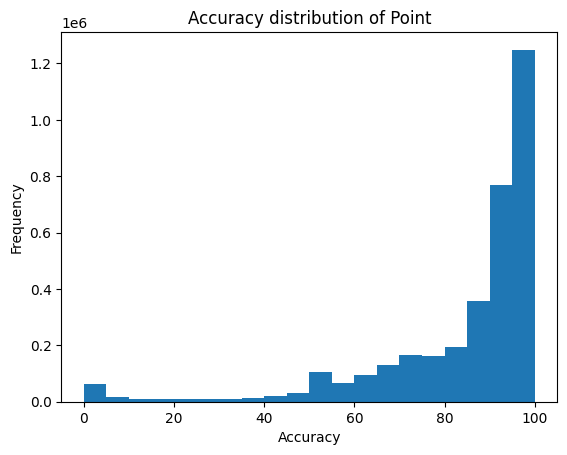

In [11]:
# 'Point' 데이터만 필터링
filtered_df = spark_df.filter((F.col('collection') == 'Point'))

# 'accuracy_array'를 개별 행으로 분리 (이미 array 타입이므로 UDF 변환 생략)
exploded_df = filtered_df.withColumn('single_accuracy', F.explode('accuracy_array'))

# # 정확도 값이 80과 100 사이인 데이터만 필터링
# final_df = exploded_df.filter((F.col('single_accuracy') >= 80) & (F.col('single_accuracy') <= 100))

# 그래프를 그리기 위해 Pandas DataFrame으로 변환
final_pdf = exploded_df.select('single_accuracy').toPandas()

# 히스토그램 그리기
plt.hist(final_pdf['single_accuracy'], bins=20)
plt.title('Accuracy distribution of Point')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

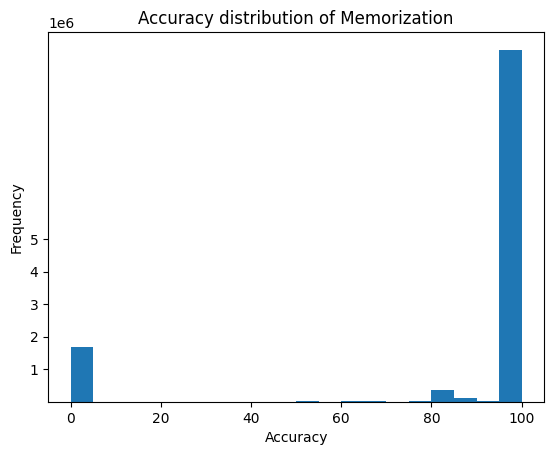

In [12]:
# 'Memorization' 데이터만 필터링
filtered_df_mem = spark_df.filter((F.col('collection') == 'Memorization'))

# 'accuracy_array'를 개별 행으로 분리
exploded_df_mem = filtered_df_mem.withColumn('single_accuracy', F.explode('accuracy_array'))

# 그래프를 그리기 위해 Pandas DataFrame으로 변환
final_pdf_mem = exploded_df_mem.select('single_accuracy').toPandas()

# 히스토그램 그리기
plt.hist(final_pdf_mem['single_accuracy'], bins=20)
plt.yticks([1e6, 2e6, 3e6, 4e6, 5e6])
plt.title('Accuracy distribution of Memorization')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

# 스크립트 길이 분포도

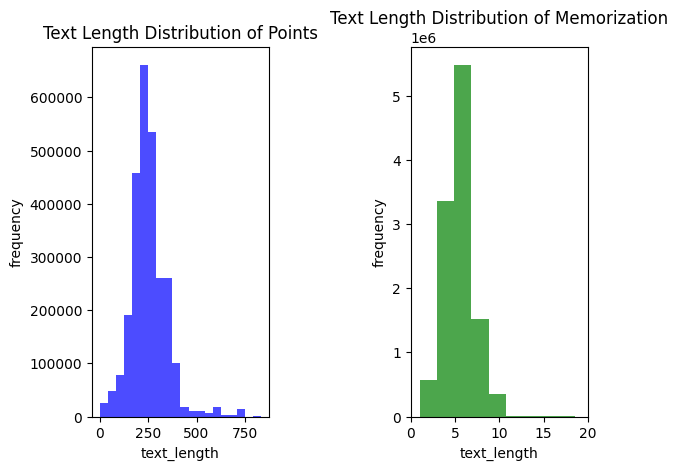

In [8]:
# 'Point'와 'Memorization' 데이터 필터링
filtered_df_point = spark_df.filter(F.col('collection') == 'Point')
filtered_df_mem = spark_df.filter(F.col('collection') == 'Memorization')

# 데이터를 Pandas DataFrame으로 변환
pdf_point = filtered_df_point.select('text_length').toPandas()
pdf_mem = filtered_df_mem.select('text_length').toPandas()

plt.subplot(1, 2, 1)
plt.hist(pdf_point['text_length'].dropna(), bins=20, color='blue', alpha=0.7, label='Point')
plt.title('Text Length Distribution of Points')
plt.xlabel('text_length')
plt.ylabel('frequency')

plt.subplot(1, 2, 2)
plt.hist(pdf_mem['text_length'].dropna(), bins=20, color='green', alpha=0.7, label='Memorization')
plt.title('Text Length Distribution of Memorization')
plt.xlabel('text_length')
plt.ylabel('frequency')
plt.xlim(0, 20)  # x축 최대값을 20으로 설정

plt.subplots_adjust(wspace=0.8)
plt.show()

# 성별 원형 차트

In [22]:
# # 'M'과 'W'만 포함하는 gender 데이터를 필터링
# filtered_gender_data = spark_df.filter(F.col('gender').isin(['M', 'W'])).groupBy('gender').count().toPandas()

# # 원형 차트 그리기
# plt.figure(figsize=(6, 6))
# plt.pie(filtered_gender_data['count'], labels=filtered_gender_data['gender'], autopct='%1.1f%%', startangle=90)
# plt.title('Gender Ratio')
# plt.show()

# 9월 이용량 분석 - CSR 이용요금 확인

In [6]:
# 'created_timestamp_array'의 모든 요소에서 날짜 부분을 추출하여 새로운 컬럼에 저장
spark_df = spark_df.withColumn(
    "extracted_dates", 
    F.expr("transform(created_timestamp_array, x -> regexp_extract(x, '(\\\\d{2}\\\\.\\\\d{2}\\\\.\\\\d{2})', 0))")
)

# 날짜 형식을 변환하여 새로운 컬럼에 저장
spark_df = spark_df.withColumn(
    "formatted_dates", 
    expr("transform(extracted_dates, x -> concat('20', substring(x, 1, 2), '-', substring(x, 4, 2), '-', substring(x, 7, 2)))")
)

# 날짜 범위에 따라 필터링
spark_df = spark_df.withColumn(
    "is_in_range",
    expr("array_contains(formatted_dates, '2023-09-01') OR (formatted_dates[0] >= '2023-09-01' AND formatted_dates[0] <= '2023-09-30')")
)

# 'collection' 값이 'Memorization' 또는 'Point' 인 행을 필터링하고 개수를 세어 집계
memorization_count = spark_df.filter((col("collection") == "Memorization") & col("is_in_range")).count()
point_count = spark_df.filter((col("collection") == "Point") & col("is_in_range")).count()

# 'collection' 값이 'Memorization' 또는 'Point'가 아닌 행을 필터링하고 개수를 세어 저장
ignored_count = spark_df.filter(~col("collection").isin(["Memorization", "Point"]) & col("is_in_range")).count()


In [7]:
# 'Memorization' 컬렉션의 수를 출력
print(f"9월 달 'Memorization' 컬렉션의 수: {memorization_count}")

# 'Point' 컬렉션의 수를 출력
print(f"9월 달 'Point' 컬렉션의 수: {point_count}")

# 무시된 행의 수를 출력
print(f"9월 달 무시된 행의 수: {ignored_count}")


9월 달 'Memorization' 컬렉션의 수: 2976621
9월 달 'Point' 컬렉션의 수: 224834
9월 달 무시된 행의 수: 0


In [8]:
# # 날짜 형식을 변환하여 새로운 컬럼에 저장하고, 날짜 범위에 맞는 데이터만 필터링합니다.
# spark_df = spark_df.withColumn(
#     "formatted_date", 
#     F.expr("concat('20', substring(extracted_dates[0], 1, 2), '-', substring(extracted_dates[0], 4, 2), '-', substring(extracted_dates[0], 7, 2))")
# ).filter(F.col("formatted_date") >= '2023-09-01').filter(F.col("formatted_date") <= '2023-09-30')

# # 날짜별로 'Memorization'과 'Point'의 개수를 계산합니다.
# daily_collection_count = spark_df.groupBy("formatted_date").pivot("collection", ["Memorization", "Point"]).count()

# # 날짜별로 'recorded'와 'unrecorded'의 개수를 계산합니다.
# spark_df = spark_df.withColumn("is_recorded", F.expr("element_at(created_timestamp_array, -1) = 'recorded'"))
# daily_record_status_count = spark_df.groupBy("formatted_date").pivot("is_recorded").count()

# # 두 집계 결과를 조인합니다.
# daily_stats = daily_collection_count.join(daily_record_status_count, "formatted_date")

In [8]:
# 날짜 형식을 변환하고, 2023년 9월 1일부터 9월 30일까지의 데이터만 필터링합니다.
spark_df = spark_df.withColumn(
    "formatted_date", 
    F.expr("concat('20', substring(extracted_dates[0], 1, 2), '-', substring(extracted_dates[0], 4, 2), '-', substring(extracted_dates[0], 7, 2))")
).filter(
    (F.col("formatted_date") >= '2023-09-01') & (F.col("formatted_date") <= '2023-09-30')
)

# 날짜별로 'Memorization'과 'Point'의 개수를 계산합니다.
daily_collection_count = spark_df.groupBy("formatted_date").pivot("collection", ["Memorization", "Point"]).count()

# 'accuracy_array'를 기반으로 'recorded', 'unrecorded', 'failed'를 계산하는 코드
spark_df = spark_df.withColumn("total_tries", F.size(F.col("accuracy_array")))

# 배열의 길이를 사용하여 마지막 요소에 접근합니다.
spark_df = spark_df.withColumn("array_length", F.size(F.col("accuracy_array")))
spark_df = spark_df.withColumn("last_accuracy", expr("accuracy_array[array_length - 1]"))

spark_df = spark_df.withColumn("recorded", F.when(F.col("accuracy_array")[-1] >= 80, 1).otherwise(0))
spark_df = spark_df.withColumn("unrecorded", F.size(F.expr("filter(accuracy_array, x -> x >= 80)")) - F.col("recorded"))
spark_df = spark_df.withColumn("failed", F.size(F.expr("filter(accuracy_array, x -> x < 80)")))

# 날짜별로 'recorded', 'unrecorded', 'failed'의 개수를 계산합니다.
daily_record_status_count = spark_df.groupBy("formatted_date").agg(
    F.sum("recorded").alias("recorded"),
    F.sum("unrecorded").alias("unrecorded"),
    F.sum("failed").alias("failed")
)

# 'total_tries'를 각 'collection' 값에 대해 계산합니다.
daily_collection_tries = spark_df.groupBy("formatted_date", "collection").agg(
    F.sum("total_tries").alias("total_tries")
).groupBy("formatted_date").pivot("collection").sum("total_tries")

# 컬럼 이름을 변경하여 중복을 피합니다.
daily_collection_tries = daily_collection_tries.withColumnRenamed("Memorization", "Memorization_total_tries") \
                                               .withColumnRenamed("Point", "Point_total_tries")

# 총합을 구하는 코드는 아래와 같습니다.
total_tries_summary = daily_collection_tries.groupBy().sum()

# 집계 결과를 조인합니다.
daily_stats = daily_collection_count.join(daily_record_status_count, "formatted_date", "left_outer")
daily_stats = daily_stats.join(daily_collection_tries, "formatted_date", "left_outer")


In [9]:
daily_stats = daily_stats.withColumn(
    "Memorization_failed", 
    F.col("Memorization_total_tries") - F.col("Memorization")
).withColumn(
    "Point_failed", 
    F.col("Point_total_tries") - F.col("Point")
)

In [10]:
# 결과를 오름차순으로 정렬하고, 모든 행을 출력합니다.
daily_stats.orderBy("formatted_date").show(n=daily_stats.count(), truncate=False)

+--------------+------------+-----+--------+----------+------+------------------------+-----------------+-------------------+------------+
|formatted_date|Memorization|Point|recorded|unrecorded|failed|Memorization_total_tries|Point_total_tries|Memorization_failed|Point_failed|
+--------------+------------+-----+--------+----------+------+------------------------+-----------------+-------------------+------------+
|2023-09-01    |79378       |9120 |0       |87200     |26974 |97048                   |17126            |17670              |8006        |
|2023-09-02    |88585       |6706 |0       |94321     |18413 |102533                  |10201            |13948              |3495        |
|2023-09-03    |83437       |6346 |0       |89012     |16390 |96945                   |8457             |13508              |2111        |
|2023-09-04    |76194       |8266 |0       |82986     |22673 |89024                   |16635            |12830              |8369        |
|2023-09-05    |93376      

In [11]:
# Spark DataFrame을 Pandas DataFrame으로 변환
pandas_df = daily_stats.orderBy("formatted_date").toPandas()

# Pandas DataFrame을 HTML로 변환하고 Jupyter Notebook에 표시
display(pandas_df)

   formatted_date  Memorization  Point  recorded  unrecorded  failed  \
0      2023-09-01         79378   9120         0       87200   26974   
1      2023-09-02         88585   6706         0       94321   18413   
2      2023-09-03         83437   6346         0       89012   16390   
3      2023-09-04         76194   8266         0       82986   22673   
4      2023-09-05         93376   8552         0      100932   18707   
5      2023-09-06         86623   7887         0       93101   35255   
6      2023-09-07         87611   7423         0       93900   23136   
7      2023-09-08         85811   7323         0       92263   19329   
8      2023-09-09         96072   5226         0      100350   23883   
9      2023-09-10        107808   4369         0      111530   17979   
10     2023-09-11        104330   6768         0      110265   21045   
11     2023-09-12        103107   8008         0      110215   20490   
12     2023-09-13        113755   7019         0      119691   2

In [12]:
# Pandas DataFrame을 HTML로 변환하고 Jupyter Notebook에 표시
display(pandas_df)

,formatted_date,Memorization,Point,recorded,unrecorded,failed,Memorization_total_tries,Point_total_tries,Memorization_failed,Point_failed
0,2023-09-01,79378,9120,0,87200,26974,97048,17126,17670,8006
1,2023-09-02,88585,6706,0,94321,18413,102533,10201,13948,3495
2,2023-09-03,83437,6346,0,89012,16390,96945,8457,13508,2111
3,2023-09-04,76194,8266,0,82986,22673,89024,16635,12830,8369
4,2023-09-05,93376,8552,0,100932,18707,107815,11824,14439,3272
5,2023-09-06,86623,7887,0,93101,35255,101694,26662,15071,18775
6,2023-09-07,87611,7423,0,93900,23136,103908,13128,16297,5705
7,2023-09-08,85811,7323,0,92263,19329,98297,13295,12486,5972
8,2023-09-09,96072,5226,0,100350,23883,115803,8430,19731,3204
9,2023-09-10,107808,4369,0,111530,17979,123600,5909,15792,1540


In [18]:
# 'accuracy_array'의 마지막 값이 80 이상인지 확인하는 코드
check_recorded_df = spark_df.withColumn("last_accuracy", F.col("accuracy_array")[-1])
check_recorded_df.select("last_accuracy").show()

+-------------+
|last_accuracy|
+-------------+
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
|         null|
+-------------+
only showing top 20 rows



# 로컬에 저장

In [15]:
print(os.environ["HADOOP_HOME"])

C:\Hadoop\hadoop-3.3.6


In [18]:
# 오늘의 날짜를 얻어 'yymmdd' 포맷으로 변환
today = datetime.today()
formatted_date = today.strftime('%y%m%d')

# 저장할 경로 설정
file_path = f"D:/DATA_PREPROCESS/FIRESTORE_DATAS/voice_metadata_parquet_{formatted_date}"

In [19]:
spark_df.repartition(300).write.parquet(file_path, mode='overwrite')